In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 3D CNN Instance Segmentation of Proteins in Cryo-ET Tomograms

This tutorial guides you through the process of training 3D U-Nets for instance segmentation of proteins in Cryo-ET tomograms. It draws inspiration from the segmentation framework introduced by E. Moebel and co-authors in DeepFinder. However, this repository introduces new developments in model architectures, data augmentations, and efficient model training, with support for datasets available on both local and remote resources.

In this notebook, we demonstrate how to utilize this infrastructure to predict the 3D coordinates of six proteins of varying sizes, provided by the CryoET Dataportal (Dataset ID: 10439). This is a synthetic dataset generated by Polnet, allowing us to reliably use the ground truth coordinates to evaluate the accuracy of our model.

The tutorial is structured into two main components:

* Data Preparation: Generating target volumes that the network will use to predict coordinates.
* Model Training: Training the 3D U-Net model.
* Optuna: Explore Several Model Configurations with Bayesian Optimization

By following this tutorial, you will gain insights into preparing data, training a 3D U-Net model for the instance segmentation of proteins in Cryo-ET tomograms.

#### Step 1: Data Preparation: Generate Targets for Training

In this step, we will prepare the target data necessary for training our model and predicting the coordinates of proteins within a tomogram.

We will use the Copick tool to manage the filesystem, extract tomogram IDs, and create spherical targets corresponding to the locations of proteins. The key tasks performed in this cell include:

Loading Parameters: We define the size of the target spheres, specify the CoPick path, voxel size, target file name, and user ID.
Generating Targets: For each tomogram, we extract particle coordinates, reset the target volume, generate spherical targets based on these coordinates, and save the target data in OME Zarr format.

In [2]:
from octopus.entry_points.run_create_targets import create_sub_train_targets, create_all_train_targets

# Copick Config
config = '/path/to/copick/config.json'

# Target Parameters
target_name = 'segmentation'
target_user_id = None               # These parameters are optional
target_session_id = None

# Tomogram Query Information - This is Used to determine the resolution that the targets will be created for. 
voxel_size = 10
tomogram_algorithm = 'wbp'

# For our segmetnation target, we can create a sphere with a diameter that is a fraction of the 
# particle radius provided in the config file.
radius_scale = 0.7

# Optional: Define A Sub-set of tomograms for generating training labels
run_ids = None

To generate the segmentation targets, we can use to optional functions that are available. 
1. We can provide a subset of pickable objects and (optionally) its userID / sessionIds. This allows for creating training targets from varying submission sources.
2. Instead of Manually specifying each individual pick targets by the name (and potentially its sessionID and/or userID). We can find all the pickable objects associated with a single query. 


In [ ]:
# Option 1: We can provide a subset of pickable objects and (optionally) its userID / sessionIds. 
# This allows for creating training targets from varying submission sources.
# Provide inputs as a list of tuples -> [ (name, userID, sessionI)]

pick_targets = [
    ('ribosome', 'data-portal', None),
    ('virus-like-capsid', 'data-portal', None),
    ('apoferritin', 'data-portal', None)
]

seg_targets = [] # Either provide this variable as an empty list or populate entries in the same format (name, userID, sessionID)

create_sub_train_targets(
    config, pick_targets, seg_targets, voxel_size, radius_scale, tomogram_algorithm,
    target_name, target_user_id, target_session_id, run_ids
)

In [ ]:
# Option 2: Instead of Manually Specifying Each pickable object, we can provide a single query 
# and it will grab the first available coordinate for each pickable object.
picks_user_id = 'data-portal'
picks_session_id = None

# In this case, we don't have any organelle segmentations that are at 10 Angstroms on the portal
seg_targets = None

create_all_train_targets(
    config, seg_targets, picks_session_id, picks_user_id, 
    voxel_size, radius_scale, tomogram_algorithm, 
    target_name, target_user_id, target_session_id, run_ids
)

#### Step 2: Training a DeepFindET 3D CNN Model

With our training target (provided in the )

In [4]:
from octopus.datasets import generators, multi_config_generator
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import ConfusionMatrixMetric
from octopus.pytorch import trainer 
import torch, mlflow, os, argparse, json
from octopus import io, utils
from typing import List, Optional

########### Input Parameters ###########

# Target Parameters
config = "/mnt/simulations/ml_challenge/ml_config.json"
target_name = 'segmentation'
target_user_id = None
target_session_id = None

# DataGenerator Parameters
num_tomo_crops = 16
tomo_algorithms = 'wbp'
voxel_size = 10
# In cases where all the tomograms can't be fit in memory, we can train on smaller batches
tomo_batch_size = 25

# Model Parameters
Nclass = 8                  # Number of classes on prediction head
channels = [32,64,128,128]  # Number of channels in each layer
strides = [2,2,1]           # Strides for the convolutional layers
res_units = 2               # Number of residual units
dim_in = 96                 # Input dimensions
model_type = 'Unet'         # Model type

model_save_path = 'results'         # Path to save the model
model_weights = None # Path to the pre-trained model weights

# Training Parameters and Frequency to Evaluate Validation Dataset
num_epochs = 60     # Number of epochs to train
val_interval = 5    # Number of epochs between validation
lr = 1e-3           # Learning rate
tversky_alpha = 0.5 # Tversky loss parameter

# Optional - Specify RunIDs
trainRunIDs = None
validateRunIDs = None

#### Prepare the training module

In [11]:
# Single-config training
data_generator = generators.TrainLoaderManager(
    config, 
    target_name, 
    target_session_id = target_session_id,
    target_user_id = target_user_id,
    tomo_algorithm = tomo_algorithms,
    voxel_size = voxel_size,
    Nclasses = Nclass,
    tomo_batch_size = tomo_batch_size )

# Get the data splits
data_generator.get_data_splits(trainRunIDs = trainRunIDs,
                                validateRunIDs = validateRunIDs)

# Get the reload frequency
data_generator.get_reload_frequency(num_epochs)

# Monai Functions
alpha = tversky_alpha
beta = 1 - alpha
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True, alpha=alpha, beta=beta)  
metrics_function = ConfusionMatrixMetric(include_background=False, metric_name=["recall",'precision','f1 score'], reduction="none")

# Create UNet Model and Load Weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = utils.create_model(model_type, Nclass, channels, strides, res_units, device)
if model_weights: 
    model.load_state_dict(torch.load(model_weights, weights_only=True))

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr, weight_decay=0.1)

# Create UNet-Trainer
model_trainer = trainer.unet(model, device, loss_function, metrics_function, optimizer)

Number of training samples: 19
Number of validation samples: 3
Number of test samples: 2
All training samples fit in memory. No reloading required.


#### Train the model

Training Progress:  24%|██▍       | 24/100 [04:59<15:10, 11.98s/epoch]

Epoch 25/100, avg_train_loss: 0.6356


Training Progress:  24%|██▍       | 24/100 [05:03<15:10, 11.98s/epoch]

Epoch 25/100, avg_f1_score: 0.8989, avg_recall: 0.5859, avg_precision: 0.5753


Training Progress:  49%|████▉     | 49/100 [10:06<10:12, 12.01s/epoch]

Epoch 50/100, avg_train_loss: 0.6147


Training Progress:  49%|████▉     | 49/100 [10:09<10:12, 12.01s/epoch]

Epoch 50/100, avg_f1_score: 0.8752, avg_recall: 0.5871, avg_precision: 0.6688


Training Progress:  74%|███████▍  | 74/100 [15:14<05:16, 12.18s/epoch]

Epoch 75/100, avg_train_loss: 0.5979


Training Progress:  74%|███████▍  | 74/100 [15:18<05:16, 12.18s/epoch]

Epoch 75/100, avg_f1_score: 0.9069, avg_recall: 0.6254, avg_precision: 0.6923


Training Progress:  99%|█████████▉| 99/100 [20:22<00:12, 12.23s/epoch]

Epoch 100/100, avg_train_loss: 0.5964


Training Progress:  99%|█████████▉| 99/100 [20:26<00:12, 12.23s/epoch]

Epoch 100/100, avg_f1_score: 0.8997, avg_recall: 0.6365, avg_precision: 0.7516


Training Progress: 100%|██████████| 100/100 [20:26<00:00, 12.27s/epoch]


Training Parameters saved to results/training_parameters.json
Training Results saved to results/results.json


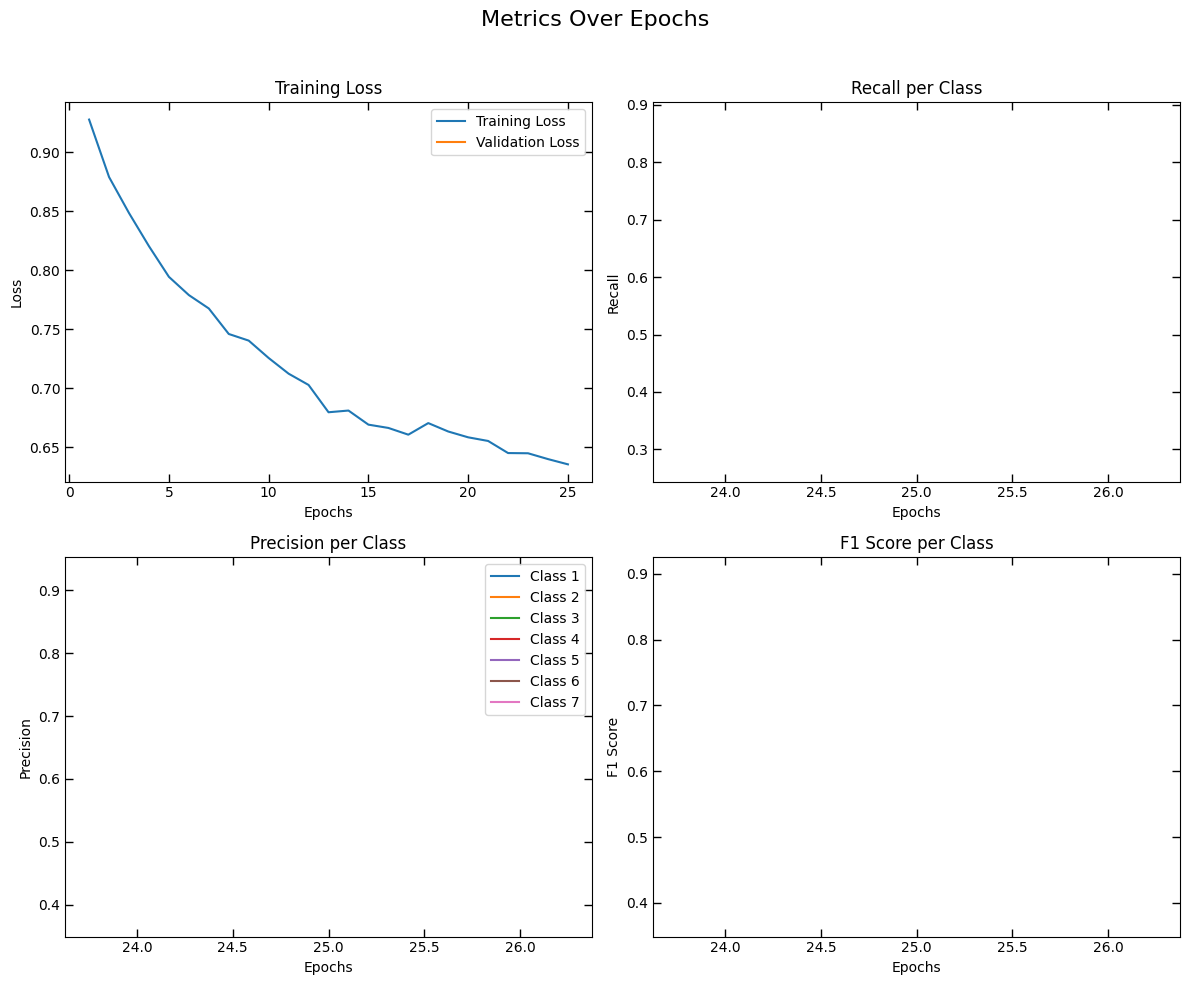

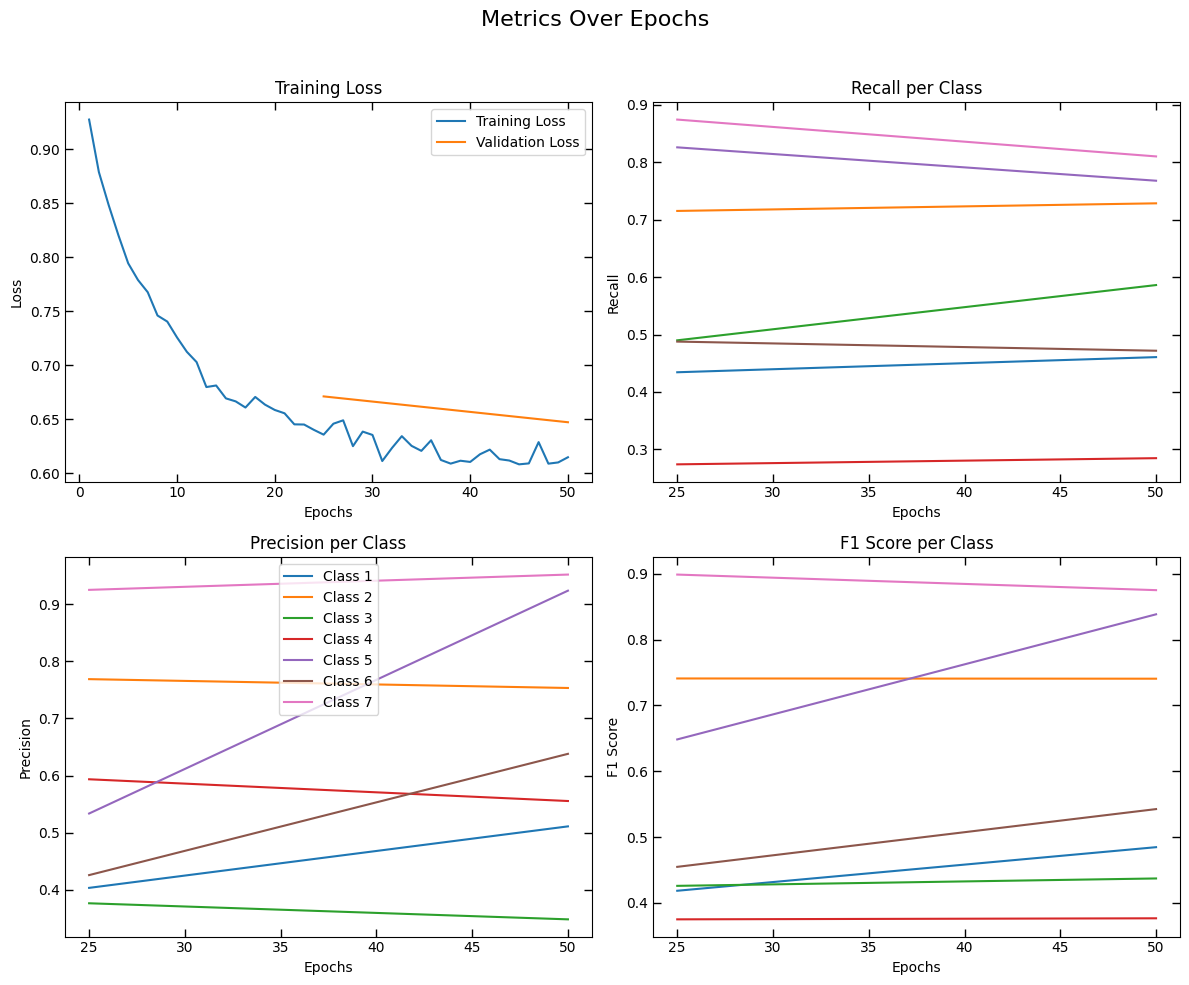

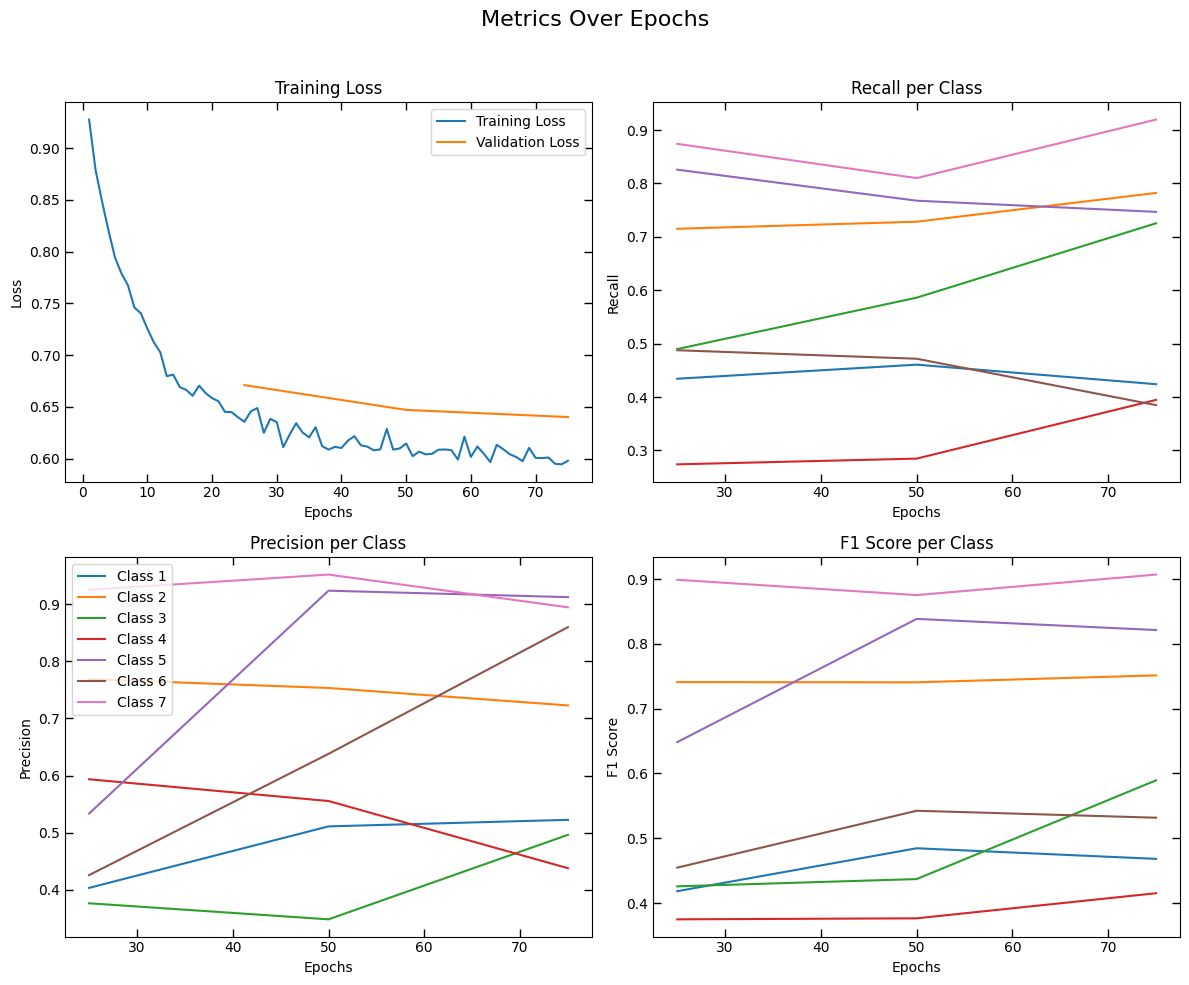

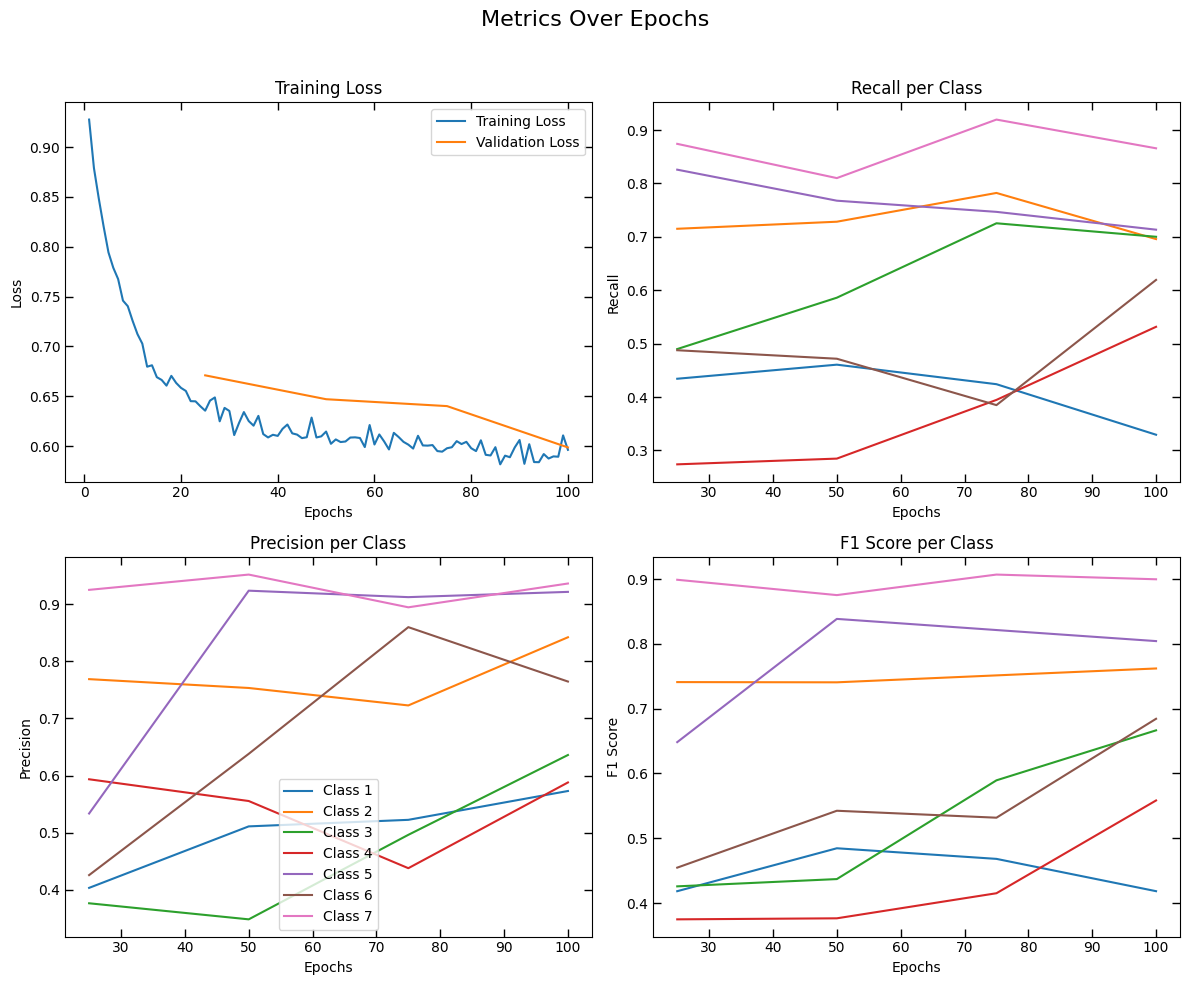

In [12]:
results = model_trainer.train(
        data_generator, model_save_path, max_epochs=num_epochs,
        crop_size=dim_in, my_num_samples=num_tomo_crops,
        val_interval=val_interval, best_metric=best_metric, verbose=True
    )

# Save parameters and results
parameters_save_name = os.path.join(model_save_path, "training_parameters.json")
io.save_parameters_to_json(model, model_trainer, data_generator, parameters_save_name)

results_save_name = os.path.join(model_save_path, "results.json")
io.save_results_to_json(results, results_save_name)